In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request
import simplejson
from cluster_model import ClusterModel
from datetime import timedelta
import pickle
import seaborn as sns

In [8]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

36 horizontal squares and 51 vertical squares. Total squares: 1836


<Axes: title={'center': '10:00:00'}>

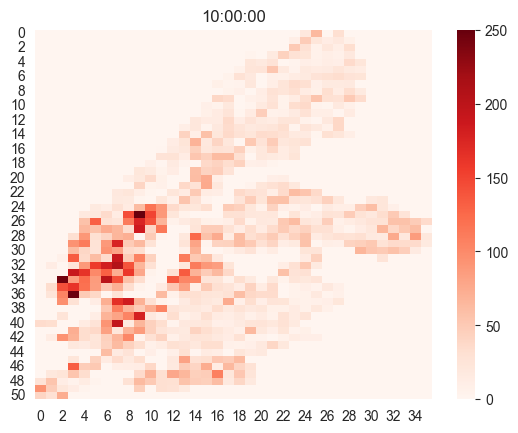

In [9]:
cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.005)
cluster_model.init_clusters()
cluster_model.init_state(path='../data/station_data/status_at_time/2024_6_21_10:17.csv', time=timedelta(hours=10))
cluster_model.show_bikes()

# num_stations = [len(cluster) for cluster in clusters]
# sns.heatmap(np.array(num_stations).reshape((vertical_squares, horizontal_squares)))

1 day, 10:15:00
1192
16257
77
-------------------
1 day, 10:30:00
1136
16511
80
-------------------
1 day, 10:45:00
1263
16794
80
-------------------
1 day, 11:00:00
1142
17057
80
-------------------
1 day, 11:15:00
1215
17327
81
-------------------
1 day, 11:30:00
1268
17601
81
-------------------
1 day, 11:45:00
1399
17885
81
-------------------
1 day, 12:00:00
1391
18161
81
-------------------
1 day, 12:15:00
1412
18450
81
-------------------
1 day, 12:30:00
1537
18760
81
-------------------
1 day, 12:45:00
1482
19058
81
-------------------
1 day, 13:00:00
1468
19353
81
-------------------
1 day, 13:15:00
1558
19663
81
-------------------
1 day, 13:30:00
1527
19988
81
-------------------
1 day, 13:45:00
1672
20343
81
-------------------
1 day, 14:00:00
1665
20711
81
-------------------
1 day, 14:15:00
1696
21044
81
-------------------
1 day, 14:30:00
1731
21370
81
-------------------
1 day, 14:45:00
1920
21690
81
-------------------
1 day, 15:00:00
1881
22030
81
-------------------


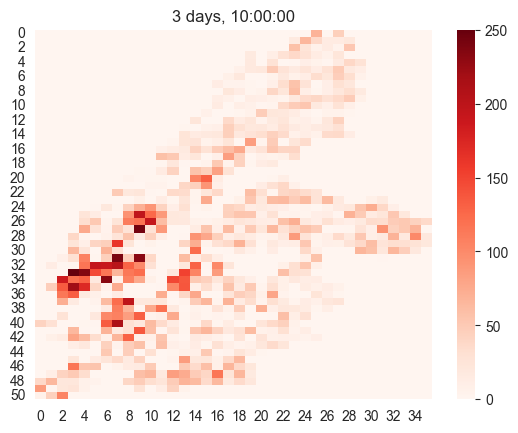

In [6]:
start_time = timedelta(hours=10)
end_time = timedelta(hours=58)
while start_time < end_time:
    cluster_model.sim()
    start_time += timedelta(minutes=15)
    print(cluster_model.curr_time)
    print(len(cluster_model.in_transit))
    print(cluster_model.failures)
    print(cluster_model.critical_failures)
    print('-------------------')
    cluster_model.show_bikes(True)

In [11]:
plt.savefig('test.png')

<Figure size 640x480 with 0 Axes>

In [108]:
cluster_model.sim()
print(cluster_model.curr_time)
print(len(cluster_model.in_transit))
print(cluster_model.failures)
print(cluster_model.critical_failures)

1 day, 12:00:00
1560
21569
33
